# Build the Hamiltonian

In [1]:
using SparseArrays
using Random

function Hamiltonian_RandomField(N,Delta,J_perp,W,seed)
    
    dim = (2)^N
    H = zeros(dim,dim)
    magz = zeros(dim)
    
    rng = MersenneTwister(seed)
    random_hi_mag = rand!(rng, zeros(N))
    random_hi_sign = 2 .*bitrand(rng, N).-1
    random_his = W.*random_hi_mag.*random_hi_sign
    
    for ket in (0:dim-1)
        
        ket_binary = bitstring(ket)
        Diagonal = Int64(0)
        random_field = Int64(0)
        
        for SpinIndex in (0:N-1) 
            
            magz[ket+1] += (2*((ket>>SpinIndex)&1)-1)
            hi = random_his[SpinIndex+1]
            random_field += hi*(2*((ket>>SpinIndex)&1)-1)
            
            if SpinIndex == N-1
                
                bit_last = Int(2)^(SpinIndex)
                bit_first = Int(2)^(0)
                flipbit_last = ket ⊻ bit_last
                flipbit_first  = flipbit_last ⊻ bit_first
                Sy_flip_last = (2*((flipbit_first>>SpinIndex)&1)-1)im
                Sy_flip_first = (2*((flipbit_first>>(0))&1)-1)im
                Sy = Sy_flip_last*Sy_flip_first
                H[flipbit_first+1,ket+1] += -(J_perp/4)*(1 + Sy)
                
                Sz_last = 2*((ket>>SpinIndex)&1)-1
                Sz_first = 2*((ket>>(0))&1)-1
                Bondz = (Delta/4)*Sz_last*Sz_first
                Diagonal += Bondz
                
                break
            end
            
            bit = Int(2)^(SpinIndex)
            nn_bit = Int(2)^(SpinIndex+1)
            flipbit = ket ⊻ bit
            Sy_flip1 = (2*((flipbit>>SpinIndex)&1)-1)im
            flipnn  = flipbit ⊻ nn_bit
            Sy_flip2 = (2*((flipnn>>(SpinIndex+1))&1)-1)im
            Sy = Sy_flip1*Sy_flip2
            H[flipnn+1,ket+1] += -(J_perp/4)*(1 + Sy)
            
            Szi = 2*((ket>>SpinIndex)&1)-1
            Szi_next = 2*((ket>>(SpinIndex+1))&1)-1
            Bondz = (Delta/4)*Szi*Szi_next
            Diagonal += Bondz
            
        end
        
        H[ket+1,ket+1] += (-1 * (Diagonal)) - random_field
        
    end
    
    H_sparse = H |> sparse
    
    return H_sparse
    
end

Hamiltonian_RandomField (generic function with 1 method)

In [ ]:
Hamiltonian_RandomField(2,1,1,5,1234)

# Calculate Entropy

In [2]:
using LinearAlgebra

function entropy(vec,N,N_A)
    dim = length(vec)
    #println("dim = ",dim)
    A_size = 2^N_A
    #println("A_spins = ",A_spins)
    #println("A_size = ",A_size)
    B_size = 2^(N-N_A) # 2^(N-N_A)
    #println("B_size should be... ",B_size)
    vec_reshaped = reshape(vec,(B_size,A_size))
    U,s,Vt= svd(vec_reshaped)
    S  = s.^2
    S_A = -S'*log.(S+0.0001*ones(length(S)))
    return S_A
end

entropy (generic function with 1 method)

# Area Law for Ground States & Volume Law for Excited States 

In [3]:
using Arpack

W_ = 0.5
num_of_runs = Int(100)
N_small = 2
N_large = 17
N_range = range(N_small,N_large,step=2)
Max_Hil = Int(2)^N_large;

In [ ]:
using JLD2
entropies_gs = zeros(length(N_range))
entropies_excited = zeros(length(N_range))

for i in (1:length(N_range))
    n = N_range[i]
    println(n)
    hil = Int(2)^n
    x = Int(n/2)
    mid_E = Int(2)^x
    entropy_total = 0
    entropy_total_gs = 0
    for j in (1:num_of_runs)
        seed = 37*i*j
        ham = Hamiltonian_RandomField(n,1,1,W_,seed)
        Es,vecs = eigs(ham, nev = mid_E, which=:SR)
        index = length(vecs[1,:])
        vec = vecs[:,index]
        vec_gs = vecs[:,1]
        entropy_total_gs += entropy(vec_gs,n,x)
        entropy_total += entropy(vec,n,x)
    end
    entropies_gs[i] = entropy_total_gs/num_of_runs
    entropies_excited[i] = entropy_total/num_of_runs #(average entropy over the number of realizations)
    save_object("NewData/entropies_gs_$(n)",entropies_gs)
    save_object("NewData/entropies_excited_$(n)",entropies_excited)
end

In [4]:
using JLD2
entropies_gs = load_object("NewData/entropies_gs_16")
entropies_excited = load_object("NewData/entropies_excited_16");

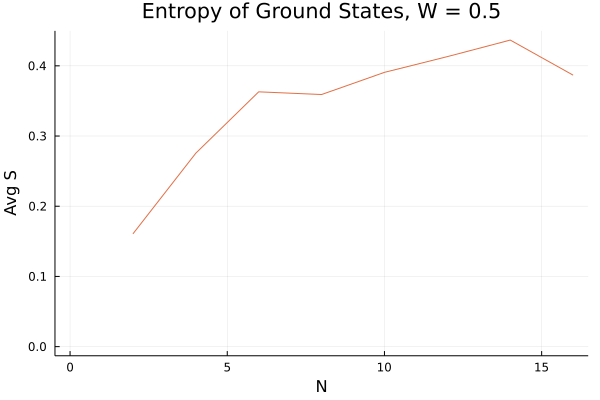

In [5]:
using Plots 

plot(title = "Entropy of Ground States, W = 0.5", xlabel = "N", ylabel = "Avg S")

zeros_ = zeros(length(N_range))

plot!(zeros_,zeros_,legend = false);
display(plot!(N_range,entropies_gs))

In [ ]:
png("NewPlots/area_gs")

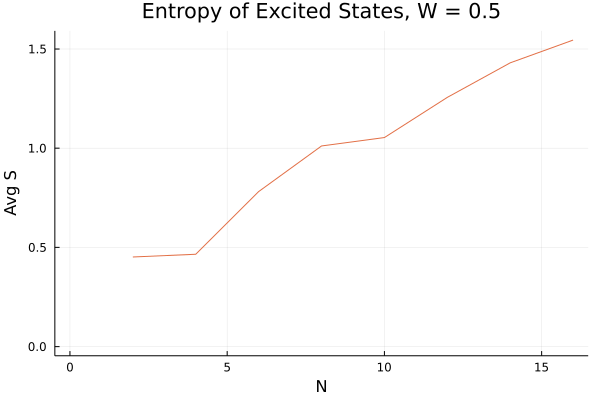

In [6]:
using Plots 

plot(title = "Entropy of Excited States, W = 0.5", xlabel = "N", ylabel = "Avg S")

zeros_ = zeros(length(N_range))

plot!(zeros_,zeros_,legend = false);
display(plot!(N_range,entropies_excited))

In [ ]:
png("NewPlots/volume_excited")

# Area Law for MBL Excited States

In [7]:
W_new = 9
num_of_runs = Int(1000)
N_small = 2
N_large_new = 15
N_range_new = range(N_small,N_large_new,step=2)
Max_Hil_new = Int(2)^N_large_new;

In [ ]:
entropies_W9 = zeros(length(N_range_new))

for i in (1:length(N_range_new))
    n = N_range_new[i]
    print(n)
    hil = Int(2)^n
    x = Int(n/2)
    mid_E = Int(2)^x
    entropy_total_W9 = 0
    for j in (1:num_of_runs)
        seed = 37*i*j
        ham = Hamiltonian_RandomField(n,1,1,W_new,seed)
        Es,vecs = eigs(ham, nev = mid_E, which=:SR)
        index = length(vecs[1,:])
        vec = vecs[:,index]
        entropy_total_W9 += entropy(vec,n,x)
    end
    entropies_W9[i] = entropy_total_W9/num_of_runs
    save_object("NewData/entropies_excited_W9_$(n)_long",entropies_W9)
end

In [11]:
entropies_W9 = load_object("NewData/entropies_excited_W9_14_long");

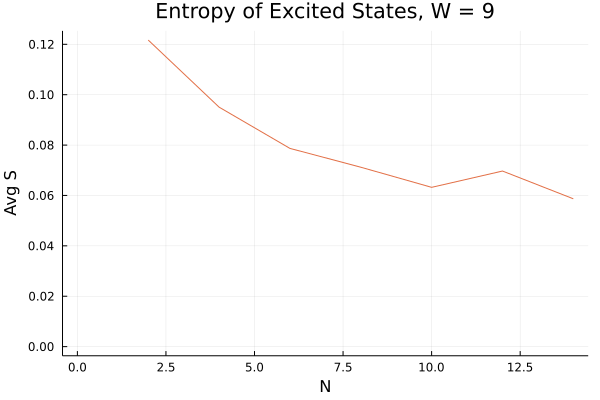

In [12]:
using Plots 

plot(title = "Entropy of Excited States, W = 9", xlabel = "N", ylabel = "Avg S")

zeros_ = zeros(length(N_range))

plot!(zeros_,zeros_,legend = false);
display(plot!(N_range_new,entropies_W9))

In [ ]:
png("NewPlots/area_excited")